# Video Semantic Search with SigLIP 2

Search inside videos using natural language queries powered by **SigLIP 2** + **ChromaDB**

## Architecture

```
INDEXING PIPELINE (Offline)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Video File ──► OpenCV ──► Frames + Timestamps ──► SigLIP2 ──► ChromaDB    │
│                 extract      (sampled @ 1fps)       embed      store        │
└─────────────────────────────────────────────────────────────────────────────┘

QUERY PIPELINE (Online)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Text Query ──► SigLIP2 ──► Query Vector ──► ChromaDB ──► Top-K Results    │
│                 embed                         search      + timestamps      │
└─────────────────────────────────────────────────────────────────────────────┘
```

## Tech Stack

| Component | Technology | Purpose |
|-----------|------------|---------|
| Frame Extraction | OpenCV | Read video, extract frames at configurable FPS |
| Embedding Model | SigLIP 2 (google/siglip2-base-patch16-224) | Image & text embeddings in shared 768-dim space |
| Vector Database | ChromaDB | Store & search embeddings with HNSW index |
| Deep Learning | PyTorch + Transformers | Model inference with GPU acceleration |

## 1. Setup & Installation

In [11]:
# Install dependencies (uncomment if needed)
# %pip install torch transformers Pillow opencv-python chromadb numpy tqdm matplotlib
!uv add torch transformers Pillow opencv-python chromadb numpy tqdm matplotlib

Resolved 147 packages in 2ms
Audited 122 packages in 0.09ms


In [12]:
import cv2
import torch
import numpy as np
from pathlib import Path
from datetime import timedelta
from PIL import Image
from tqdm import tqdm
import chromadb
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt

# Check device - prefer CUDA for faster inference
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
VRAM: 4.0 GB


## 2. Configuration

All configurable parameters in one place with justifications.

In [13]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

# SigLIP 2 base model - fastest variant with 768-dim embeddings
# Alternatives: siglip2-large-patch16-384 (1024-dim), siglip2-so400m-patch14-384 (1152-dim)
MODEL_NAME = "google/siglip2-base-patch16-224"

# Embedding dimension for base model (changes with model variant)
EMBEDDING_DIM = 768

# =============================================================================
# FRAME EXTRACTION CONFIGURATION  
# =============================================================================

# Sample rate in frames per second
# 1.0 = extract 1 frame every second (good balance of coverage vs storage)
# 2.0 = extract 2 frames per second (more granular, 2x storage)
# 0.5 = extract 1 frame every 2 seconds (less granular, half storage)
SAMPLE_RATE = 1.0

# =============================================================================
# EMBEDDING CONFIGURATION
# =============================================================================

# Batch size for processing frames through the model
# 16 works well for 8GB VRAM with base model in float16
# Reduce to 8 if you encounter OOM errors
BATCH_SIZE = 16

# =============================================================================
# SEARCH CONFIGURATION
# =============================================================================

# Number of results to return from similarity search
TOP_K = 10

# =============================================================================
# STORAGE CONFIGURATION
# =============================================================================

# Directory structure
DATA_DIR = Path("./data")
VIDEOS_DIR = DATA_DIR / "videos"
DB_DIR = DATA_DIR / "chroma_db"

# Create directories
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)
DB_DIR.mkdir(parents=True, exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"Sample rate: {SAMPLE_RATE} fps")
print(f"Batch size: {BATCH_SIZE}")
print(f"Videos directory: {VIDEOS_DIR}")
print(f"Database directory: {DB_DIR}")

Model: google/siglip2-base-patch16-224
Sample rate: 1.0 fps
Batch size: 16
Videos directory: data\videos
Database directory: data\chroma_db


## 3. Load SigLIP 2 Model

Load the vision-language encoder with memory optimizations:
- **float16**: Reduces memory usage by 50% with minimal quality loss
- **SDPA**: Scaled Dot-Product Attention for efficient GPU computation

In [14]:
print(f"Loading model: {MODEL_NAME}")

# Load model with optimizations
# - torch_dtype=float16: Half precision for 50% memory savings
# - attn_implementation="sdpa": PyTorch's efficient attention
# - device_map="auto": Automatically place on GPU if available
model = AutoModel.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16,
    attn_implementation="sdpa",
    device_map="auto"
).eval()  # Set to evaluation mode (disables dropout)


# Load processor (handles image preprocessing and text tokenization)
processor = AutoProcessor.from_pretrained(MODEL_NAME)


print(f"Model loaded successfully!")
print(f"Model device: {model.device}")
print(f"Image embedding dimension: {model.config.vision_config.hidden_size}")

Loading model: google/siglip2-base-patch16-224


Loading weights: 100%|██████████| 408/408 [00:02<00:00, 145.40it/s, Materializing param=vision_model.post_layernorm.weight]                      


Model loaded successfully!
Model device: cuda:0
Image embedding dimension: 768


## 4. Frame Extraction

Extract frames from video at a configurable sample rate using OpenCV.

**Key formula**: `timestamp_seconds = frame_index / fps`

In [15]:
def extract_frames(video_path: str, sample_rate: float = SAMPLE_RATE):
    """
    Extract frames from video at specified sample rate.
    
    Args:
        video_path: Path to video file
        sample_rate: Frames per second to extract (1.0 = 1 frame/sec)
    
    Returns:
        frames: List of RGB frames (numpy arrays)
        metadata: List of dicts with timestamp info
        video_info: Dict with video properties
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = total_frames / fps if fps > 0 else 0
    
    video_info = {
        "fps": fps,
        "total_frames": total_frames,
        "width": width,
        "height": height,
        "duration": duration
    }
    
    print(f"Video Info:")
    print(f"  - FPS: {fps:.2f}")
    print(f"  - Total Frames: {total_frames}")
    print(f"  - Resolution: {width}x{height}")
    print(f"  - Duration: {timedelta(seconds=int(duration))}")
    
    # Calculate sampling interval
    # If video is 30fps and sample_rate is 1.0, we take every 30th frame
    frame_interval = max(1, int(fps / sample_rate))
    expected_frames = total_frames // frame_interval
    print(f"  - Sampling: 1 frame every {frame_interval} frames ({sample_rate} fps)")
    print(f"  - Expected extracted frames: ~{expected_frames}")
    
    frames = []
    metadata = []
    frame_idx = 0
    
    pbar = tqdm(total=total_frames, desc="Extracting frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % frame_interval == 0:
            # Convert BGR (OpenCV default) to RGB (what models expect)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            
            # Calculate timestamp: frame_index / fps = seconds
            timestamp = frame_idx / fps
            
            metadata.append({
                "frame_idx": frame_idx,
                "timestamp": timestamp,
                "timestamp_str": str(timedelta(seconds=int(timestamp))),
            })
        
        frame_idx += 1
        pbar.update(1)
    
    pbar.close()
    cap.release()
    
    print(f"\nExtracted {len(frames)} frames")
    return frames, metadata, video_info


def get_frame_at_index(video_path: str, frame_idx: int):
    """Retrieve a single frame from video at specific index (for displaying results)."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return None

## 5. Embedding Functions

Generate embeddings using SigLIP 2:
- **Images**: Batch process frames through vision encoder
- **Text**: Encode queries through text encoder

Both produce vectors in the same 768-dimensional space, enabling cross-modal similarity search.

In [22]:
def embed_images(frames: list, batch_size: int = BATCH_SIZE):
    """
    Generate embeddings for a list of frames using SigLIP 2.
    
    Args:
        frames: List of RGB numpy arrays
        batch_size: Number of frames to process at once (reduce if OOM)
    
    Returns:
        embeddings: numpy array of shape (n_frames, EMBEDDING_DIM)
    """
    all_embeddings = []
    
    for i in tqdm(range(0, len(frames), batch_size), desc="Generating embeddings"):
        batch = frames[i:i + batch_size]
        
        # Process batch through the processor (resizes, normalizes)
        inputs = processor(images=batch, return_tensors="pt").to(model.device)
        
        with torch.no_grad():
            # Use get_image_features for image-only embedding
            # Returns BaseModelOutputWithPooling, access pooler_output for embeddings
            outputs = model.get_image_features(**inputs)
            embeddings = outputs.pooler_output
            
            # L2 normalize embeddings (required for cosine similarity)
            # This projects all vectors onto the unit sphere
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
        
        all_embeddings.append(embeddings.cpu())
    
    return torch.cat(all_embeddings, dim=0).numpy()


def embed_text(query: str):
    """
    Generate embedding for a text query using SigLIP 2.
    
    Args:
        query: Natural language search query
    
    Returns:
        embedding: numpy array of shape (1, EMBEDDING_DIM)
    """
    # IMPORTANT: Use padding="max_length" and max_length=64 because SigLIP2 was trained this way
    inputs = processor(
        text=[query], 
        padding="max_length",  # Critical: model was trained with max_length padding
        max_length=64,         # SigLIP2 uses max_length=64
        return_tensors="pt"
    ).to(model.device)
    
    with torch.no_grad():
        # Use get_text_features for text-only embedding
        # Returns BaseModelOutputWithPooling, access pooler_output for embeddings
        outputs = model.get_text_features(**inputs)
        embedding = outputs.pooler_output
        
        # L2 normalize (same as images)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    
    return embedding.cpu().numpy()

## 6. ChromaDB Vector Database

Set up persistent vector storage with HNSW index for fast similarity search.

**Why ChromaDB?**
- Simple Python API
- Automatic HNSW indexing (O(log n) search)
- Persistent storage to disk
- Metadata filtering support

In [23]:
# Initialize ChromaDB with persistent storage
# Data is automatically saved to disk at DB_DIR
chroma_client = chromadb.PersistentClient(path=str(DB_DIR))

# Create or get collection for video frames
# Using cosine similarity (appropriate for normalized embeddings)
collection = chroma_client.get_or_create_collection(
    name="video_frames",
    metadata={"hnsw:space": "cosine"}  # Cosine distance for similarity search
)

print(f"Collection: {collection.name}")
print(f"Current frame count: {collection.count()}")


def get_database_stats():
    """Get statistics about the indexed database."""
    total_frames = collection.count()
    
    print("\nDatabase Statistics")
    print("=" * 40)
    print(f"Total indexed frames: {total_frames}")
    
    if total_frames > 0:
        # Get unique video IDs
        all_data = collection.get(include=["metadatas"])
        video_ids = set(m.get("video_id", "unknown") for m in all_data["metadatas"])
        print(f"Total videos: {len(video_ids)}")
        print(f"\nIndexed videos:")
        for v in video_ids:
            print(f"  - {v}")
    print("=" * 40)


def clear_database():
    """Clear all data from the collection (use with caution!)."""
    global collection
    chroma_client.delete_collection("video_frames")
    collection = chroma_client.create_collection(
        name="video_frames",
        metadata={"hnsw:space": "cosine"}
    )
    print("Database cleared!")

Collection: video_frames
Current frame count: 0


## 7. Video Indexing Pipeline

The main indexing function that orchestrates:
1. Frame extraction (OpenCV)
2. Embedding generation (SigLIP 2)
3. Vector storage (ChromaDB)

In [24]:
def index_video(video_path: str, video_id: str, sample_rate: float = SAMPLE_RATE):
    """
    Index a video into ChromaDB for semantic search.
    
    Args:
        video_path: Path to video file
        video_id: Unique identifier for this video (used in search results)
        sample_rate: Frames per second to extract
    
    Returns:
        num_frames: Number of frames indexed
    """
    print(f"\n{'='*60}")
    print(f"Indexing video: {video_id}")
    print(f"{'='*60}\n")
    
    # Step 1: Extract frames from video
    frames, metadata, video_info = extract_frames(video_path, sample_rate)
    
    if len(frames) == 0:
        raise ValueError("No frames extracted from video")
    
    # Step 2: Generate embeddings for all frames
    print("\nGenerating embeddings...")
    embeddings = embed_images(frames)
    print(f"Embeddings shape: {embeddings.shape}")
    
    # Step 3: Prepare data for ChromaDB
    # Create unique IDs for each frame
    ids = [f"{video_id}_frame_{m['frame_idx']}" for m in metadata]
    
    # Add video info to metadata
    for m in metadata:
        m["video_id"] = video_id
        m["video_path"] = str(video_path)
    
    # Step 4: Store in ChromaDB
    print("\nStoring in ChromaDB...")
    collection.add(
        ids=ids,
        embeddings=embeddings.tolist(),
        metadatas=metadata
    )
    
    print(f"\nSuccessfully indexed {len(frames)} frames from '{video_id}'")
    print(f"Total frames in database: {collection.count()}")
    
    return len(frames)

## 8. Search Functions

Search indexed videos using natural language queries.

In [25]:
def search(query: str, top_k: int = TOP_K):
    """
    Search for frames matching the text query.
    
    Args:
        query: Natural language search query (e.g., "a person writing on whiteboard")
        top_k: Number of results to return
    
    Returns:
        results: List of dicts with video_id, timestamp, score, etc.
    """
    print(f"\nSearching for: '{query}'")
    
    # Embed the query text
    query_embedding = embed_text(query)
    
    # Search ChromaDB
    results = collection.query(
        query_embeddings=query_embedding.tolist(),
        n_results=top_k,
        include=["metadatas", "distances"]
    )
    
    # Format results
    search_results = []
    for i in range(len(results["ids"][0])):
        meta = results["metadatas"][0][i]
        distance = results["distances"][0][i]
        
        # Convert cosine distance to similarity score
        # ChromaDB returns distance (0 = identical, 2 = opposite)
        # We convert to similarity (1 = identical, -1 = opposite)
        score = 1 - distance
        
        search_results.append({
            "rank": i + 1,
            "video_id": meta["video_id"],
            "video_path": meta.get("video_path", ""),
            "timestamp": meta["timestamp"],
            "timestamp_str": meta["timestamp_str"],
            "frame_idx": meta["frame_idx"],
            "score": score,
        })
    
    print(f"Found {len(search_results)} results\n")
    return search_results


def display_search_results(results, max_display: int = 5):
    """
    Display search results with frame thumbnails.
    
    Args:
        results: List of result dicts from search()
        max_display: Maximum number of results to display
    """
    if not results:
        print("No results to display")
        return
    
    # Print text results
    print("Results:")
    print("-" * 70)
    for r in results[:max_display]:
        print(f"#{r['rank']} | {r['video_id']} | Time: {r['timestamp_str']} | Score: {r['score']:.4f}")
    print("-" * 70)
    
    # Load and display frames
    frames = []
    titles = []
    
    for r in results[:max_display]:
        frame = get_frame_at_index(r["video_path"], r["frame_idx"])
        if frame is not None:
            frames.append(frame)
            titles.append(f"#{r['rank']} {r['timestamp_str']}\nScore: {r['score']:.3f}")
    
    if frames:
        # Create figure with subplots
        n = len(frames)
        cols = min(n, 5)
        rows = (n + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        if n == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if rows > 1 else axes
        
        for i, ax in enumerate(axes):
            if i < n:
                ax.imshow(frames[i])
                ax.set_title(titles[i], fontsize=9)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

---

# Demo Usage

Now let's use the pipeline to index and search videos.

## Index a Video

Update the `VIDEO_PATH` below to point to your video file.

In [31]:
# =============================================================================
# UPDATE THESE VALUES FOR YOUR VIDEO
# =============================================================================

VIDEO_PATH = "./data/videos/video.mp4"  # Path to your video file
VIDEO_ID = "sample_video"                 # Unique identifier for this video

# =============================================================================

# Check if video exists and index it
if Path(VIDEO_PATH).exists():
    num_frames = index_video(VIDEO_PATH, VIDEO_ID, sample_rate=SAMPLE_RATE)
else:
    print(f"Video not found: {VIDEO_PATH}")
    print("\nPlease update VIDEO_PATH to point to your video file.")
    print(f"You can place videos in: {VIDEOS_DIR.absolute()}")


Indexing video: sample_video

Video Info:
  - FPS: 30.00
  - Total Frames: 907
  - Resolution: 1920x1080
  - Duration: 0:00:30
  - Sampling: 1 frame every 30 frames (1.0 fps)
  - Expected extracted frames: ~30


Extracting frames: 100%|██████████| 907/907 [00:05<00:00, 157.38it/s]



Extracted 31 frames

Generating embeddings...


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

Embeddings shape: (31, 768)

Storing in ChromaDB...

Successfully indexed 31 frames from 'sample_video'
Total frames in database: 42


## Check Database Stats

In [32]:
get_database_stats()


Database Statistics
Total indexed frames: 42
Total videos: 1

Indexed videos:
  - sample_video


## Search Videos

Try different natural language queries to find matching moments in your indexed videos.


Searching for: 'a snail with its shell'
Found 3 results

Results:
----------------------------------------------------------------------
#1 | sample_video | Time: 0:00:20 | Score: 0.1378
#2 | sample_video | Time: 0:00:19 | Score: 0.1354
#3 | sample_video | Time: 0:00:09 | Score: 0.0913
----------------------------------------------------------------------


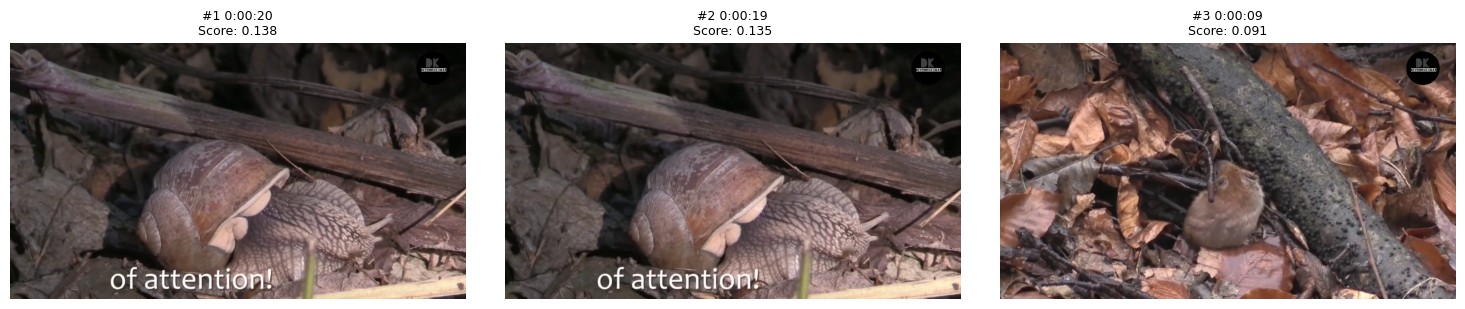

In [40]:
# Example search query - update this to match your video content
query = "a snail with its shell"

results = search(query, top_k=3)
display_search_results(results)


Searching for: 'a moving car over a cross walk'
Found 5 results

Results:
----------------------------------------------------------------------
#1 | sample_video | Time: 0:00:06 | Score: 0.1766
#2 | sample_video | Time: 0:00:04 | Score: 0.1479
#3 | sample_video | Time: 0:00:01 | Score: 0.1477
#4 | sample_video | Time: 0:00:05 | Score: 0.1427
#5 | sample_video | Time: 0:00:02 | Score: 0.1397
----------------------------------------------------------------------


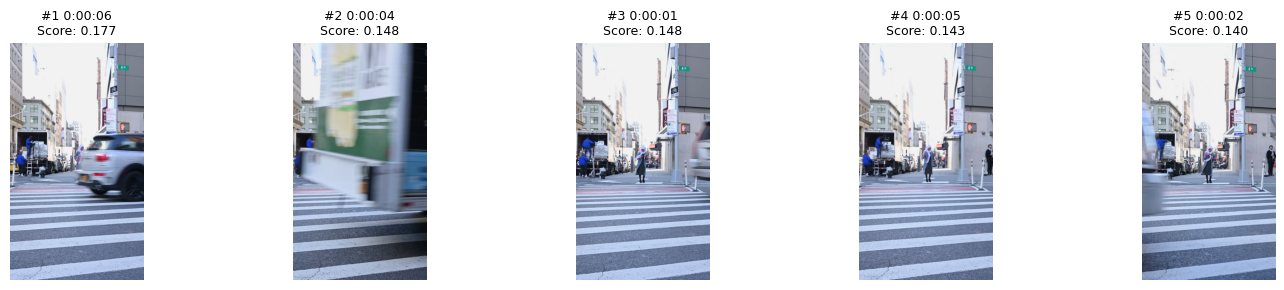

In [29]:
# Try another query
query = "a moving car over a cross walk"

results = search(query, top_k=5)
display_search_results(results)

## Batch Search (Multiple Queries)

In [30]:
# Test multiple queries at once
test_queries = [
    "car",
    "a lady",
    "stop sign across cross walk",
    "people with blue color shirt",
]

for q in test_queries:
    results = search(q, top_k=3)
    if results:
        print(f"Query: '{q}'")
        for r in results:
            print(f"  -> {r['timestamp_str']} (score: {r['score']:.3f})")
        print()


Searching for: 'car'
Found 3 results

Query: 'car'
  -> 0:00:06 (score: 0.098)
  -> 0:00:08 (score: 0.098)
  -> 0:00:03 (score: 0.087)


Searching for: 'a lady'
Found 3 results

Query: 'a lady'
  -> 0:00:02 (score: 0.088)
  -> 0:00:00 (score: 0.084)
  -> 0:00:00 (score: 0.077)


Searching for: 'stop sign across cross walk'
Found 3 results

Query: 'stop sign across cross walk'
  -> 0:00:05 (score: 0.136)
  -> 0:00:07 (score: 0.136)
  -> 0:00:00 (score: 0.131)


Searching for: 'people with blue color shirt'
Found 3 results

Query: 'people with blue color shirt'
  -> 0:00:08 (score: 0.074)
  -> 0:00:10 (score: 0.061)
  -> 0:00:03 (score: 0.059)



---

## Clean Up (Optional)

In [ ]:
# Uncomment to clear all indexed data
# clear_database()

---

## Summary

This notebook implements a complete video semantic search pipeline:

| Step | Function | Description |
|------|----------|-------------|
| 1 | `extract_frames()` | Extract frames from video at configurable FPS using OpenCV |
| 2 | `embed_images()` | Generate 768-dim SigLIP 2 embeddings for frames |
| 3 | `embed_text()` | Generate 768-dim SigLIP 2 embedding for text query |
| 4 | `index_video()` | Full indexing pipeline (extract -> embed -> store) |
| 5 | `search()` | Find matching frames using cosine similarity |
| 6 | `display_search_results()` | Visualize results with thumbnails |

### Key Parameters

| Parameter | Value | Purpose |
|-----------|-------|---------|
| `MODEL_NAME` | `google/siglip2-base-patch16-224` | Vision-language encoder |
| `SAMPLE_RATE` | `1.0` | Frames per second to extract |
| `BATCH_SIZE` | `16` | Frames per embedding batch |
| `TOP_K` | `10` | Search results to return |

### Next Steps

1. Index more videos to build a larger searchable collection
2. Experiment with different sample rates for your use case
3. Build a Streamlit app with video upload and playback